In [1]:
import os, sys
sys.path.append("../..")


In [2]:
import csv
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

from src.evolution.mutations import combined, mab, lin2opt, relocate_block, double_bridge, point_exchange
from src.evolution.run_evolution import run_evolution
from src.graph_utils.Graph import Graph, Mode
from src.visualization.draw_graph import draw_orders, draw_graph


In [3]:
# rewrite the statistics file

# with open('../../data/convergence/statistics.csv', 'w') as f:
#     writer = csv.writer(f)

#     header = ['size', 'from_index', 'lo_progress', 'lo_time', 'lo_epochs', 'db_progress', 'db_time', 'db_epochs', 'pe_progress', 'pe_time', 'pe_epochs', 'rb_progress', 'rb_time', 'rb_epochs', 'cmb_progress', 'cmb_time', 'cmb_epochs', 'mab_progress', 'mab_time', 'mab_epochs', 'mab_lo_pulls', 'mab_db_pulls', 'mab_pe_pulls', 'mab_ce_pulls', 'mab_rb_pulls']

#     writer.writerow(header)


In [4]:
def print_path(evolution, ax_hist, ax_result, mutation_str):
    hist = evolution.get_fitness_hist()
    ax_hist.scatter([i for i, _ in enumerate(hist)], hist)
    best_path = evolution.get_best_path()
    draw_graph(ax_result, best_path)

    ax_hist.set_title(f'{mutation_str} fitness hist')
    ax_result.set_title(f'{mutation_str} result')
    

In [5]:
def get_statistics(size, n_ep, pool, from_index=0):
    df = pd.read_csv('../../data/taxi/coordinates_by_id.csv', sep=',')
    
    with open('../../data/taxi_partly/coordinates_by_id.csv', 'w') as f:
        writer = csv.writer(f)
        header = ['coord_x', 'coord_y']
        writer.writerow(header)
        for key, row in tqdm(df.iterrows()):
            writer.writerow(row)

    df = pd.read_csv('../../data/taxi/orders.csv', sep=',')
    
    df = df.sample(frac=1)
    # .sample(frac=1, random_state=42)
    
    with open('../../data/taxi_partly/orders.csv', 'w') as f:
        writer = csv.writer(f)
        header = ['from', 'to']
        writer.writerow(header)
        for key, row in tqdm(df.iloc[from_index:from_index+size].iterrows()):
            writer.writerow(row)

    g = Graph(Mode.IDS, dataset_dir="taxi_partly")
    g.set_path_weight(g.get_path_weight())
    
    evolution_lo = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=lin2opt, initial_graph=g)
    evolution_db = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=double_bridge, initial_graph=g)
    evolution_pe = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=point_exchange, initial_graph=g)
    evolution_rb = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=relocate_block, initial_graph=g)
    evolution_cmb = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=combined, initial_graph=g)
    evolution_mab = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=mab, initial_graph=g)
    
    fig, ((ax00, ax10),
          (ax01, ax02),
          (ax11, ax12),
          (ax21, ax22),
          (ax31, ax32),
          (ax41, ax42),
          (ax51, ax52)) = plt.subplots(nrows=7, ncols=2, figsize=(10, 35))
    
    ax00.set_title('orders')
    draw_orders(ax00, dataset_dir='taxi_partly')
    ax10.set_title('start path')
    draw_graph(ax10, g)
    
    print_path(evolution_lo, ax01, ax02, 'lin2opt')
    print_path(evolution_db, ax11, ax12, 'double_bridge')
    print_path(evolution_pe, ax21, ax22, 'point_exchange')
    print_path(evolution_rb, ax31, ax32, 'relocate_block')
    print_path(evolution_cmb, ax41, ax42, 'combined')
    print_path(evolution_mab, ax51, ax52, 'bandit')
    
    with open('../../data/convergence/statistics.csv','a') as f:
        writer = csv.writer(f)
        row = [size, from_index,
               evolution_lo.progress, evolution_lo.time, evolution_lo.epochs,
               evolution_db.progress, evolution_db.time, evolution_db.epochs,
               evolution_pe.progress, evolution_pe.time, evolution_pe.epochs,
               evolution_rb.progress, evolution_rb.time, evolution_rb.epochs,
               evolution_cmb.progress, evolution_cmb.time, evolution_cmb.epochs,
               evolution_mab.progress, evolution_mab.time, evolution_mab.epochs,
               *evolution_mab.pulls]

        writer.writerow(row)


8130it [00:00, 34015.71it/s]
50it [00:00, 15340.15it/s]
99it [00:00, 1012770.97it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 477.55it/s]


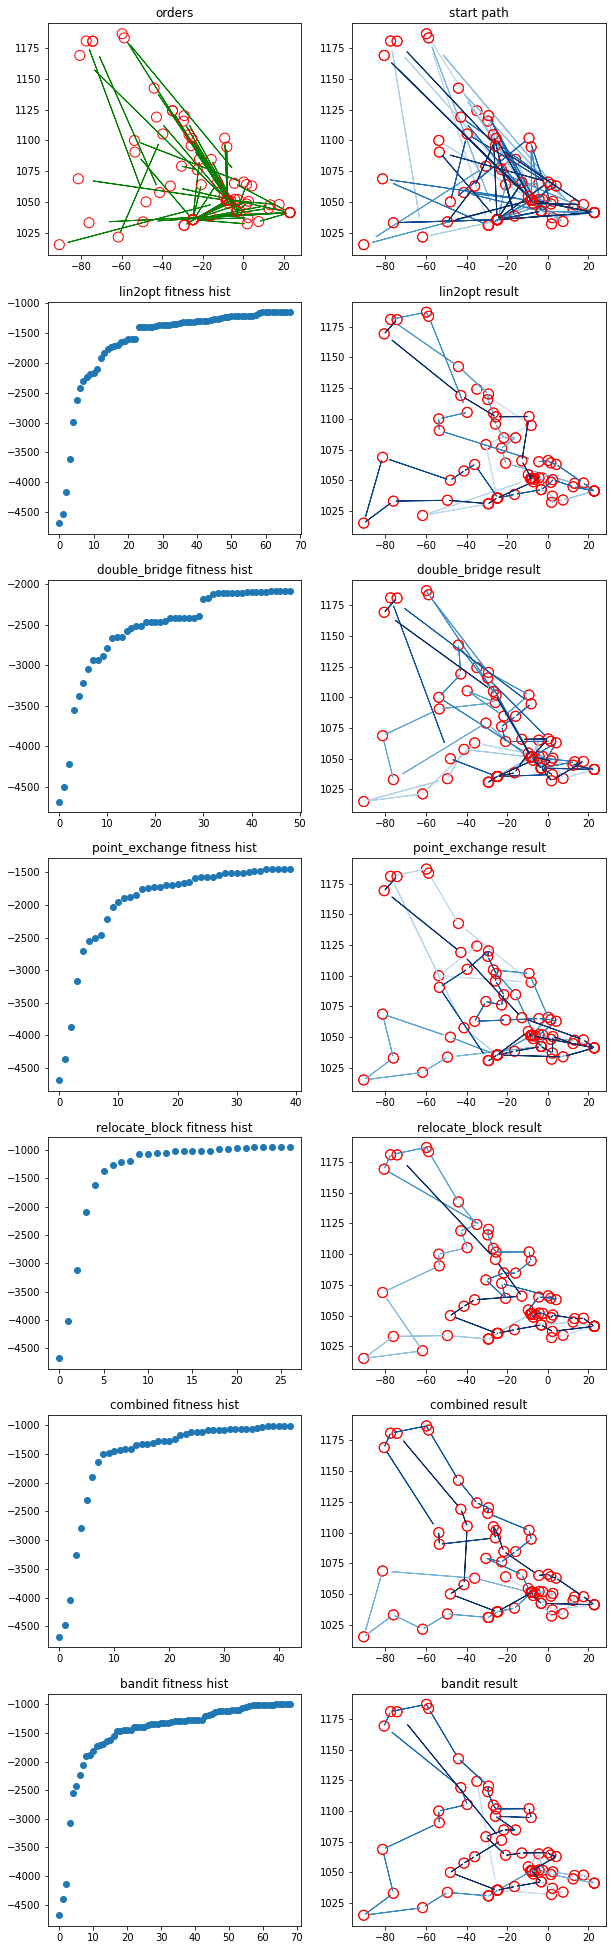

In [6]:
get_statistics(size=50, n_ep=100, pool=50, from_index = 0)


In [7]:
df = pd.read_csv('../../data/convergence/statistics.csv', sep=',')
(df.drop(['from_index'], axis=1)).head(10)

,size,lo_progress,lo_time,lo_epochs,db_progress,db_time,db_epochs,pe_progress,pe_time,pe_epochs,...,cmb_time,cmb_epochs,mab_progress,mab_time,mab_epochs,mab_lo_pulls,mab_db_pulls,mab_pe_pulls,mab_ce_pulls,mab_rb_pulls
0,10,56.61,0:00:01,9,45.85,0:00:01,10,53.53,0:00:01,10,...,0:00:02,11,63.91,0:00:01,12,459,170,165,175,2031
1,20,63.06,0:00:04,19,50.35,0:00:04,24,51.01,0:00:04,13,...,0:00:05,22,69.55,0:00:05,21,325,318,329,317,3961
2,40,70.76,0:00:13,52,50.12,0:00:12,28,65.06,0:00:13,55,...,0:00:15,27,77.23,0:00:15,38,598,591,585,546,7180
3,80,68.73,0:00:42,100,56.26,0:00:40,71,71.42,0:00:42,83,...,0:00:47,67,85.07,0:00:47,55,1041,801,871,779,10258
4,80,77.55,0:00:39,95,62.18,0:00:40,99,70.54,0:00:41,100,...,0:00:47,81,81.66,0:00:47,70,1112,1109,1080,1045,13154
5,80,78.69,0:00:39,84,59.42,0:00:39,62,73.46,0:00:41,100,...,0:00:45,58,82.37,0:00:45,50,780,702,763,754,9501
6,80,78.98,0:00:38,98,62.08,0:00:38,80,74.10,0:00:39,100,...,0:00:47,98,83.59,0:00:41,39,602,579,640,529,7400
7,80,79.67,0:00:36,73,68.48,0:00:38,73,72.44,0:00:39,100,...,0:00:44,80,85.03,0:00:41,45,768,893,698,656,8235
8,80,77.17,0:00:38,97,54.41,0:00:35,50,70.30,0:00:40,100,...,0:00:42,43,82.65,0:00:44,58,917,867,853,871,10992
9,200,71.12,0:01:47,100,50.88,0:02:23,100,68.05,0:02:42,100,...,0:03:55,100,88.28,0:03:59,100,1454,1541,1453,1468,19084


In [8]:
(df.drop(['from_index'], axis=1))[['size', 'lo_progress', 'db_progress', 'pe_progress', 'rb_progress', 'cmb_progress', 'mab_progress']].head(10)

,size,lo_progress,db_progress,pe_progress,rb_progress,cmb_progress,mab_progress
0,10,56.61,45.85,53.53,56.56,62.69,63.91
1,20,63.06,50.35,51.01,70.48,68.37,69.55
2,40,70.76,50.12,65.06,74.60,74.60,77.23
3,80,68.73,56.26,71.42,85.08,81.79,85.07
4,80,77.55,62.18,70.54,82.43,80.40,81.66
5,80,78.69,59.42,73.46,83.44,81.89,82.37
6,80,78.98,62.08,74.10,84.89,83.54,83.59
7,80,79.67,68.48,72.44,85.72,85.13,85.03
8,80,77.17,54.41,70.30,83.54,79.20,82.65
9,200,71.12,50.88,68.05,89.39,85.15,88.28
